## Analysis of Chicago Homicides 1957 - 2016

In [26]:
#######################################
#       Loaded Pkgs
#######################################

library(dplyr)
library(ggplot2)
library(tidyr)
library(forecast)
library(scales) 

In [27]:
#######################################
#         Load File
#######################################

## set universal plot size:
options(repr.plot.width=6, repr.plot.height=4)

#  working directory
setwd("C:/Users/whitf/Documents/R Scripts")

# read file
chicago <-read.csv("chitrib_r2.csv",stringsAsFactors = TRUE,header=T, sep=",",na.strings= c(" ", "NA"))

### Analysis Overview 

This is a brief analysis of the monthly homicide data as reported by the Chicago Police Department and published by the Chicago Tribune. Data used in this analysis is from the March 2016 Chicago Tribune article, "Data: Chicago homicide data since 1957", (http://www.chicagotribune.com/news/local/breaking/ct-chicago-homicides-data-since-1957-20160302-htmlstory.html). Homicides are noted as criminal or unlawful killings. Supplemental data pertaining to the residing administrations are added for further context. This analysis  compares homicides over the past 59 years.

In [28]:
# view dataset 
glimpse(chicago) 

Observations: 59
Variables: 22
$ X1              <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...
$ year            <int> 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 196...
$ X               <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ january         <int> 12, 19, 26, 29, 31, 35, 22, 20, 31, 40, 48, 43, 39,...
$ february        <int> 21, 20, 26, 29, 19, 34, 23, 30, 25, 30, 41, 44, 37,...
$ march           <int> 16, 20, 15, 25, 36, 33, 29, 34, 34, 31, 50, 47, 45,...
$ april           <int> 25, 29, 20, 35, 27, 17, 25, 24, 36, 40, 42, 51, 63,...
$ may             <int> 29, 34, 25, 28, 38, 26, 24, 39, 27, 28, 41, 58, 71,...
$ june            <int> 28, 27, 26, 35, 38, 41, 36, 39, 27, 26, 52, 45, 61,...
$ july            <int> 32, 22, 42, 40, 29, 35, 28, 50, 40, 72, 49, 46, 68,...
$ august          <int> 31, 28, 41, 35, 38, 33, 39, 26, 50, 52, 37, 64, 67,...
$ september       <int> 29, 29, 27, 29, 31, 34, 43, 38, 27, 53, 50, 55, 68,...
$ october         <in

### Tenure of Each Administration 

The presiding Mayor or administration are aligned with the periods in which they held office.  Since the data is from 1957 to 2007, the initial data for Richard M. Daily's are not included.  Richard M. Daily's tenure lasted from April 20, 1955-December 20, 1976. Similarly this analysis does not include data from 2016 forward to capture current data for residing Mayor of Chicago, Rahm Emanuel. Results depict monthly and yearly murders across several administrations.  Below recaps the tenure of each Mayor stemming from Richard M. Daily with the longest at 23 years and Michael A. Bilandic with less than 3 years in office. For ease of interpretation, years are rounded to the nearest whole number.  

In [29]:
chi_long <- chicago %>%  
        gather('month' ,'homicide_cnt', january:december) %>% 
        arrange (year) %>%
        select( year, month, homicide_cnt) 

# create date field
library(zoo)
chi_long$months <-1:12 # create numeric month field
chi_long<-within(chi_long, date <- sprintf("%d-%02d", year, months))  # concat year and month as char 
chi_long$date<- as.Date(as.yearmon(chi_long$date))

chi_long <- chi_long %>% mutate(mayor = case_when(
                  date < "1977-01-01"  ~ "Richard J. Daley",
                  year = 1977 & date <=  "1979-04-01"  ~ "Michael A. Bilandic",
                  date >= "1979-05-01"  & date <=  "1983-04-01"  ~ "Jane Margaret Byrne",
                  date >= "1983-05-01"  & date <=  "1987-11-01"  ~ "Harold Washington",
                  date >= "1987-12-01"  & date <=  "1989-4-01"  ~ "Eugene Sawyer",
                  date >= "1989-05-01"  & date <=  "2011-4-01"  ~ "Richard M. Daley",
                  date >= "2011-05-01"   ~ "Rahm Emanuel"
                ))



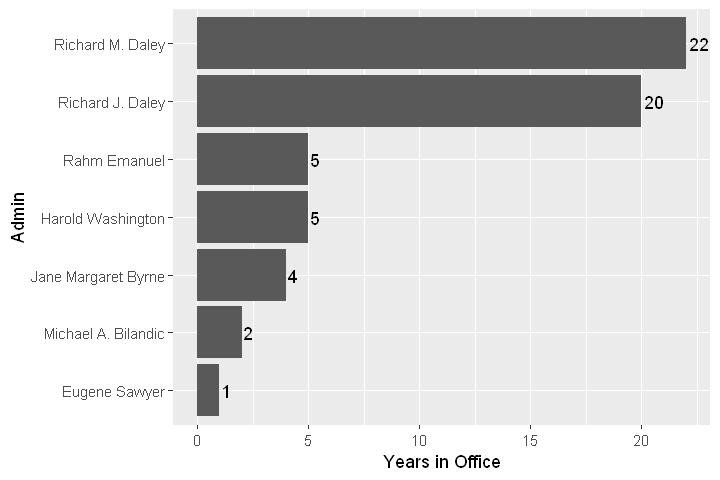

In [30]:
# term in office - serving as mayor 
tenure <-chi_long %>% 
                select (date, mayor) %>% 
                group_by(mayor) %>%
                tally() %>%
                rename(months_in_office = n) %>%
                mutate(months_prop = round(months_in_office/sum(months_in_office),2),
                        years_in_office = round(months_in_office/12,0),
                        years_prop = round(months_in_office/sum(months_in_office),2))

# visual term in office by year                 
ggplot(tenure, aes(x = reorder(mayor, years_in_office), y = years_in_office)) + 
        geom_bar(stat = "identity") +
        coord_flip()+
        scale_y_continuous(name="Years in Office") +
        scale_x_discrete(name="Admin") +
        geom_text(aes(label= years_in_office), position=position_dodge(width=0.01), hjust=-0.15) 



### Homicide Count by Administration

The homicide counts for Richard J. Daley and Richard M. Daley are expected to be exponentially more than the other administrations given their tenure in office.  Below summaries the total number of homicides under each administration. The figures are assumed to be influenced to some degree by economic factors, political climates and/or weather which are not quantified in the data to any significant detail.


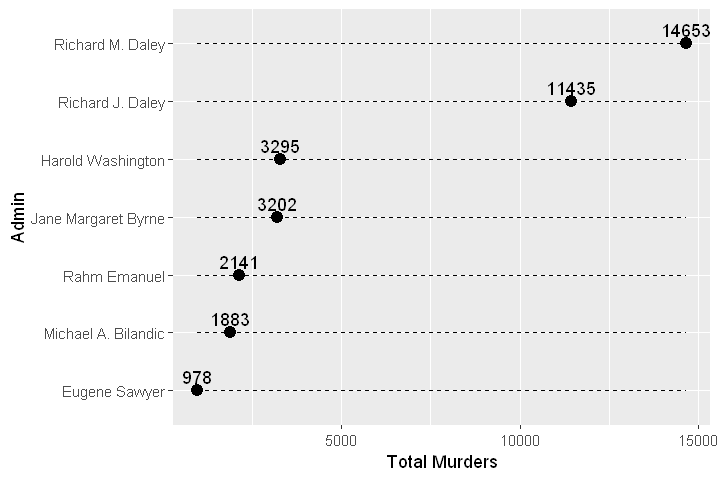

In [31]:
# murders count during tenure        
murders_by_mayor<-chi_long %>% 
                        select (mayor, homicide_cnt) %>% 
                        group_by(mayor) %>%
                        summarise(total_murders = sum(homicide_cnt)) %>%
                        mutate(proportion = total_murders/sum(total_murders))


# Plot
#ggplot(murders_by_mayor, aes(x=mayor,y = total_murders)) + 
ggplot(murders_by_mayor, aes(x = reorder(mayor, total_murders), y = total_murders))+
  geom_point( size=3) +   # Draw points
  geom_segment(aes(x=mayor, 
                   xend=mayor, 
                   y=min(total_murders), 
                   yend=max(total_murders)), 
               linetype="dashed", 
               size=0.01) +
        scale_y_continuous(name="Total Murders") +
        scale_x_discrete(name="Admin") +
        geom_text(aes(label= total_murders), position=position_dodge(width=0.5), vjust=-0.50) +
  coord_flip()


In [32]:
murder_by_year <-chi_long %>% group_by(year) %>%  summarise(total_murders = sum(homicide_cnt)) %>%
                        mutate(proportion = round(total_murders/sum(total_murders),2))

### Homicide Patterns

Recent homicide patterns suggest a recent downward trend with murders peaking in 1974 and 1992 at 970 and 943 respectively. 

In [33]:
murder_by_year  %>% filter (proportion == 0.03)

year,total_murders,proportion
1974,970,0.03
1992,943,0.03


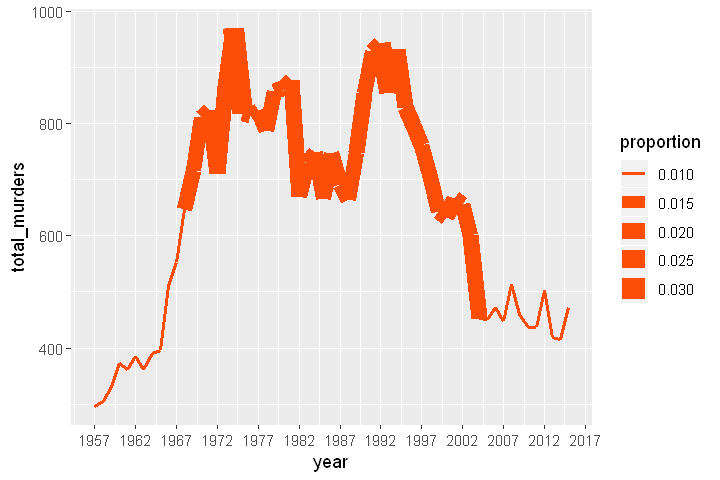

In [34]:

ggplot(data = murder_by_year, aes(x = year ,y = total_murders)) +
  geom_line(aes(size = proportion), color = "#FC4E07") +
        #scale_x_continuous(breaks=c(1957, 1967, 1977, 1987, 1997, 2007, 2017))
        scale_x_continuous(breaks=c(1957, 1962,1967,1972,1977,1982,1987,1992,1997,2002,2007,2012,2017))


### Seasonal Patterns  

Homicides over the past 59 years generally peak in the summer months. Administrations of 4 years or more exhibit similar patterns which are not captured by administrations of lesser duration. 

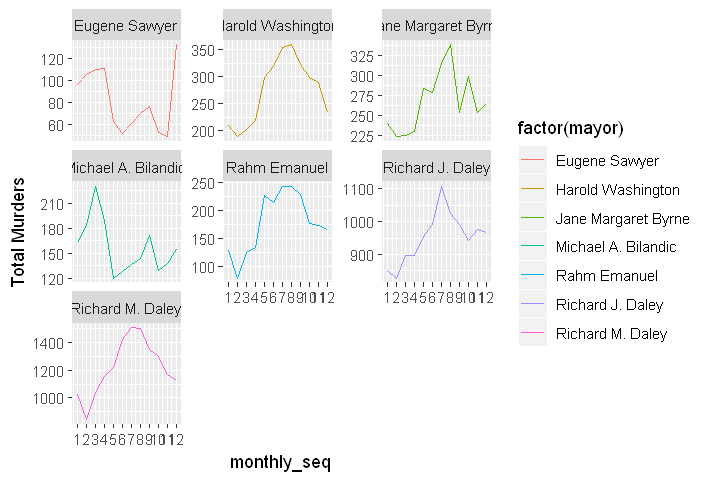

In [35]:

# insert numeric month 
# overall deadliest months in chicago
deadliest_months<-chi_long %>% 
                        select (month,mayor,homicide_cnt) %>% 
                        group_by(mayor,month) %>%
                                 #filter (mayor, -contains('Daley'))
                        summarise(total_murders = sum(homicide_cnt)) %>%
                        mutate(proportion = round(total_murders/sum(total_murders),2),
                                monthly_seq = case_when(  month == 'january' ~ 1,
                                                          month == 'february' ~ 2,
                                                          month == 'march' ~ 3,
                                                          month == 'april' ~ 4,
                                                          month == 'may' ~ 5,
                                                          month == 'june' ~ 6,
                                                          month == 'july' ~ 7,
                                                          month == 'august' ~ 8,
                                                          month == 'september' ~ 9,
                                                          month == 'october' ~ 10,
                                                          month == 'november'~ 11,
                                                          month == 'december' ~ 12 ))   

chicago <-read.csv("chitrib_r2.csv",stringsAsFactors = TRUE,header=T, sep=",",na.strings= c(" ", "NA"))

ggplot(deadliest_months, aes(monthly_seq,total_murders, colour = factor(mayor))) + 
        geom_line(stat = "identity") +
        facet_wrap(~mayor, scales="free_y") + 
        scale_x_continuous(breaks=c(1:12, 1)) +
        scale_y_continuous(name="Total Murders") 



### Percent Change in Homicide: 2010-2013 vs 2013-2016

In [36]:

rate_2010_2013 <-chi_long %>% 
                        group_by(month) %>% 
                        filter(year >=2010 ,year <=2013) %>% 
                                summarise( rate_2010_2013 = mean(homicide_cnt)) 

                                   
rate_2013 <-chi_long %>% 
                        group_by(month) %>% 
                        filter(year > 2013) %>% 
                        summarise(rate_2013 = mean(homicide_cnt))


combo_avg_rate<-inner_join(rate_2013, rate_2010_2013, by = 'month')


combo_avg_rate<-combo_avg_rate %>% mutate(perc_change = round((rate_2013-rate_2010_2013)/rate_2010_2013,2),
                                          monthly_seq = case_when(  month == 'january' ~ 1,
                                                          month == 'february' ~ 2,
                                                          month == 'march' ~ 3,
                                                          month == 'april' ~ 4,
                                                          month == 'may' ~ 5,
                                                          month == 'june' ~ 6,
                                                          month == 'july' ~ 7,
                                                          month == 'august' ~ 8,
                                                          month == 'september' ~ 9,
                                                          month == 'october' ~ 10,
                                                          month == 'november'~ 11,
                                                          month == 'december' ~ 12 )) %>% arrange (monthly_seq)

overall_mean<-combo_avg_rate %>% summarize (avg = round(mean (perc_change),2))


The mean percentage change in homicide between 2010 - 2013 and 2013 - 2016 is -0.01. On average, the mean percentage change during this period declined -0.22 and -0.18 in January and October respectively, partially offset by an increase of 0.35 in September.


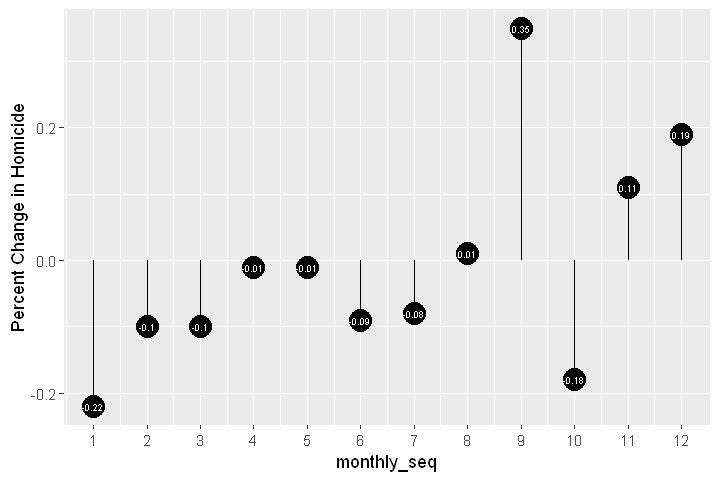

In [38]:
# Plot
ggplot(combo_avg_rate, aes(x= monthly_seq, y=perc_change, label=perc_change)) + 
  geom_point(stat='identity', fill="black", size=6)  +
  geom_segment(aes(y = 0, 
                   x = monthly_seq, 
                   yend = perc_change, 
                   xend = monthly_seq), 
               color = "black") +
  geom_text(color="white", size=2) +
       scale_x_continuous(breaks=c(1:12, 1)) +
       scale_y_continuous(name="Percent Change in Homicide") 